In [2]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
import six
from sklearn.metrics import roc_curve
import datetime
%matplotlib inline

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
ecgData = np.load("/media/john/SAMSUNG/CNN/3D-conv/ecgData.npy")
ecgClass = np.load("/media/john/SAMSUNG/CNN/3D-conv/ecgClass.npy")
unseenData = np.load("/media/john/SAMSUNG/CNN/3D-conv/unseenData.npy")
unseenClass = np.load("/media/john/SAMSUNG/CNN/3D-conv/unseenClass.npy")

In [4]:
def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

ecgData = ecgData[..., np.newaxis]
unseenData = unseenData[..., np.newaxis]
ecgClassOH = processClassData(ecgClass)
unseenClassOH = processClassData(unseenClass)

# Neural Network

In [5]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, 63, 19, 17, 1])

# First layer:
net = tflearn.layers.conv.conv_3d(net, 8, [5,5,5],  activation="leaky_relu", padding="valid")
net = tflearn.layers.conv.max_pool_3d(net, 3, padding='valid', strides=3)

# Second layer:
net = tflearn.layers.conv.conv_3d(net, 16, [5,5,5], activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 3, strides=3)

# Fully connected layer
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')

model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(ecgData[:,::32], ecgClassOH, batch_size=4, n_epoch=10, show_metric=True, validation_set=0.2)

Training Step: 719  | total loss: 0.10468 | time: 183.048s
| Adam | epoch: 010 | loss: 0.10468 - acc: 0.9832 -- iter: 284/288
Training Step: 720  | total loss: 0.10719 | time: 189.337s
| Adam | epoch: 010 | loss: 0.10719 - acc: 0.9849 | val_loss: 0.44044 - val_acc: 0.8194 -- iter: 288/288
--


In [ ]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, 500, 19, 17, 1])

# First layer:
net = tflearn.layers.conv.conv_3d(net, 8, [10,5,5],  activation="leaky_relu", padding="valid")
net = tflearn.layers.conv.max_pool_3d(net, 2, padding='valid', strides=2)

# Second layer:
net = tflearn.layers.conv.conv_3d(net, 16, [5,5,5], activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

# Fully connected layer
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')

model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(ecgData[:,::4], ecgClassOH, batch_size=32, n_epoch=10, show_metric=True, validation_set=0.2)

Training Step: 12  | total loss: 0.61898 | time: 1370.373s
| Adam | epoch: 002 | loss: 0.61898 - acc: 0.6374 -- iter: 096/288


In [5]:
model.fit(ecgData[:,500::20], ecgClassOH, batch_size=32, n_epoch=150, show_metric=True, validation_set=0.2)

Training Step: 2699  | total loss: 0.00713 | time: 221.764s
| Adam | epoch: 300 | loss: 0.00713 - acc: 0.9994 -- iter: 256/288
Training Step: 2700  | total loss: 0.00686 | time: 254.782s
| Adam | epoch: 300 | loss: 0.00686 - acc: 0.9995 | val_loss: 0.07180 - val_acc: 0.9583 -- iter: 288/288
--


In [6]:
#model.save("./outData/models/3d_conv.tflearn")
#model.load("/media/john/SAMSUNG/CNN/3D-conv/3d_conv.tflearn")

In [11]:
def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

iUnseen, hUnseen = splitData(unseenData, unseenClass)
unseenHL = np.tile([1,0], (len(hUnseen), 1))
unseenIL = np.tile([0,1], (len(iUnseen), 1))
iUnseen = np.reshape(iUnseen, (-1,2000,19,17,1))
hUnseen = np.reshape(hUnseen, (-1,2000,19,17,1))

print(model.evaluate(unseenData[:,500::20], unseenClassOH),"\n",\
    model.evaluate(np.array(iUnseen)[:,500::20], unseenIL),"\n",\
    model.evaluate(np.array(hUnseen)[:,500::20], unseenHL))

([0.80000001192092896], '\n', [0.75], '\n', [0.85000002384185791])


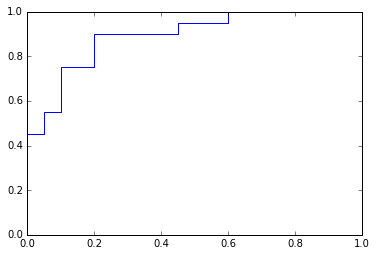

In [9]:
# Get ROC curve
#if k == 1:
predicted = np.array(model.predict(np.array(unseenData)[:,500::20]))
fpr, tpr, th = roc_curve(unseenClass, predicted[:,1])
plt.plot(fpr,tpr)

In [8]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

[u'InputData/X',
 u'Conv3D/W/Initializer/random_uniform/shape',
 u'Conv3D/W/Initializer/random_uniform/min',
 u'Conv3D/W/Initializer/random_uniform/max',
 u'Conv3D/W/Initializer/random_uniform/RandomUniform',
 u'Conv3D/W/Initializer/random_uniform/sub',
 u'Conv3D/W/Initializer/random_uniform/mul',
 u'Conv3D/W/Initializer/random_uniform',
 u'Conv3D/W',
 u'Conv3D/W/Assign',
 u'Conv3D/W/read',
 u'Conv3D/b/Initializer/Const',
 u'Conv3D/b',
 u'Conv3D/b/Assign',
 u'Conv3D/b/read',
 u'Conv3D/Conv3D',
 u'Conv3D/BiasAdd',
 u'Conv3D/LeakyReLU/Relu',
 u'Conv3D/LeakyReLU/Neg',
 u'Conv3D/LeakyReLU/Relu_1',
 u'Conv3D/LeakyReLU/mul/x',
 u'Conv3D/LeakyReLU/mul',
 u'Conv3D/LeakyReLU/sub',
 u'MaxPool3D/MaxPool3D',
 u'Conv3D_1/W/Initializer/random_uniform/shape',
 u'Conv3D_1/W/Initializer/random_uniform/min',
 u'Conv3D_1/W/Initializer/random_uniform/max',
 u'Conv3D_1/W/Initializer/random_uniform/RandomUniform',
 u'Conv3D_1/W/Initializer/random_uniform/sub',
 u'Conv3D_1/W/Initializer/random_uniform/mul',


In [14]:
model.net.v

In [26]:
model.net.graph.get_tensor_by_name('Conv3D/W:0').re


AttributeError: 'Tensor' object has no attribute 'value'

In [16]:
var = [v for v in tf.trainable_variables() if v.name == "Conv3D/W:0"][0]

In [27]:
var.value

<tf.Tensor 'read_2:0' shape=(2, 5, 5, 1, 16) dtype=float32>

In [28]:
data = model.get_weights(var)

In [35]:
np.shape(data.T)

(16, 1, 5, 5, 2)

In [36]:
convlist=[]
for i in range(16):
    convlist.append(data.T[i])

In [39]:
np.shape(convlist[0][0].T[0])

(5, 5)

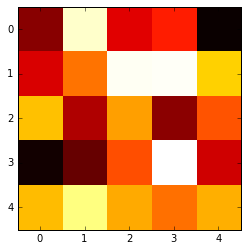

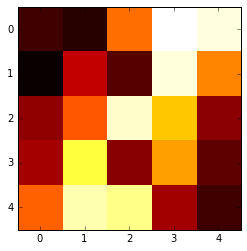

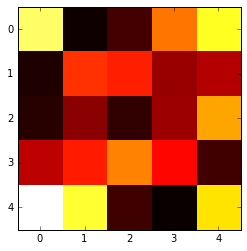

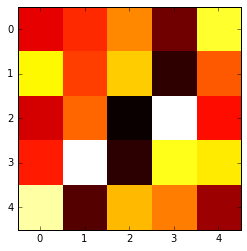

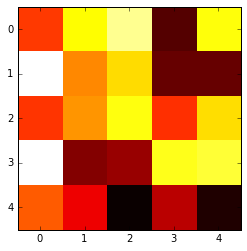

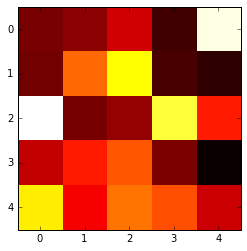

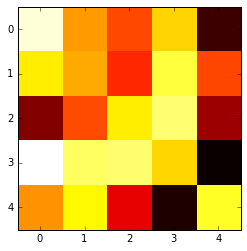

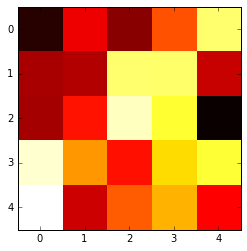

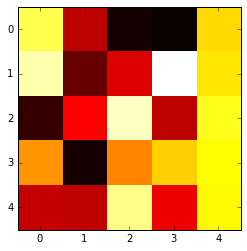

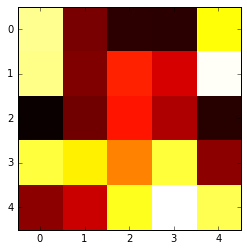

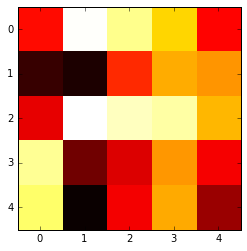

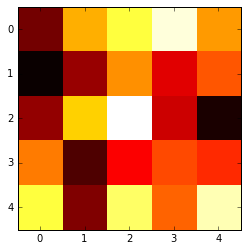

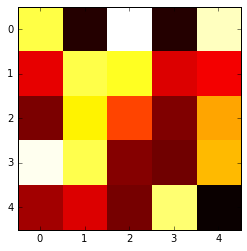

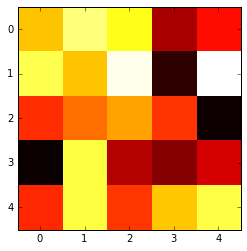

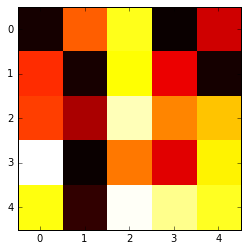

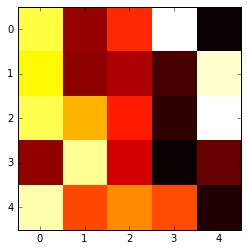

In [47]:
for i in range(16):
    plt.imshow(convlist[i][0].T[1], cmap='hot', interpolation='nearest')
    plt.show()

In [46]:
for i in range(16):
    print "min ", (convlist[i][0].T[1]).min(), " max ", (convlist[i][0].T[0]).max()

min  -0.21539  max  0.241762
min  -0.213183  max  0.191789
min  -0.235446  max  0.238051
min  -0.216743  max  0.23038
min  -0.164489  max  0.17918
min  -0.236026  max  0.227304
min  -0.237941  max  0.238175
min  -0.242936  max  0.206579
min  -0.235494  max  0.220981
min  -0.228415  max  0.206411
min  -0.245406  max  0.220464
min  -0.226809  max  0.243428
min  -0.241068  max  0.23751
min  -0.24382  max  0.216684
min  -0.229107  max  0.240074
min  -0.222312  max  0.184815
